In [1]:
import SimpleITK as sitk
import os
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# LABELS : creation of a list of vectors --> manual classification
# IMG 53 
y_g1_53 = np.zeros(512)
y_g1_53[172:214] = 1
y_g1_53[311:347] = 1

# IMG 54
y_g1_54 = np.zeros(512)
y_g1_54[160:203] = 1
y_g1_54[290:326] = 1

# IMG 55 
y_g1_55 = np.zeros(512)
y_g1_55[180:226] = 1
y_g1_55[291:332] = 1

# list of vectors (one per image to provide to the function)
label = np.concatenate((y_g1_53, y_g1_54, y_g1_55))

In [3]:
def image_to_slices (image):
    
    '''
    the function takes a 3D image and converts it to sagital slices 
    It returns a list of slices
    
    '''
    shape = image.GetSize()
    image_array = sitk.GetArrayFromImage(image)   
    image_slices = []
    for i in range (shape[0]):
        sl_array = image_array[:,:,i]
        # from image to array reverse the image up down 
        sl_array = np.flipud(sl_array)
        image_slices.append(sl_array)
    
    return image_slices


In [4]:
def get_slices_from_paths(im_list):
    """
    function to convert image paths list of numpy images of slices
    :param im_list: list of paths to .nii.gz images
    :return: slice_list: list of 2D numpy arrays containing image slices
    """
    slice_list = []
    # each image has to be converted in sagital slice
    for j in range(len(im_list)):
        # read image
        image = sitk.ReadImage(im_list[j], sitk.sitkFloat32, imageIO="NiftiImageIO")
        # create a list of slices
        slice_list += image_to_slices(image)

    return slice_list

In [5]:
import cv2
def preprocess_images(image, input_size):
    """
    Function to preprocess slices of image.
    :param image: list of 2D numpy arrays that contain saggital slices of hip/femur as numpy array
    :param input_size: input shape of image to reshape
    :return:
    """
    input_size = (input_size[1], input_size[0]) # opencv takes y first and then x
    image_preprocessed = [cv2.resize(slice, input_size) for slice in image]
    image_preprocessed = [(slice - np.min(slice)) / (np.max(slice) - np.min(slice)) for slice in image_preprocessed]
    image_preprocessed = [slice[..., np.newaxis] for slice in image_preprocessed]

    print(image_preprocessed[0].max())

    return image_preprocessed

In [6]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras import applications, Model

def GetLeNet(n_base=32, input_shape=(128, 128, 1)):
    """Definition of leNet tensor flow network architecture
    """
    # Building the following LeNet architecture step by step
    model = Sequential()
    # First layer: 32 2D convolutional with size of 3by3 with "rectified linear unit" as activation function.
    model.add(Conv2D(n_base, kernel_size=(3, 3), activation='relu',  strides=1, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    # Second layer: 2D layer: pooling layer (max-pooling) with the size of 2by2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 3rd layer: 64 2D convolutional with size of 3by3 with "rectified linear unit" as activation function.
    model.add(Conv2D(2*n_base, (3, 3), activation='relu', strides=1, padding='same'))
    model.add(BatchNormalization())
    # 4th layer: pooling layer (max-pooling) with the size of 2by2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Vectorize the resulted image
    model.add(Flatten())
    # 5th layer: fully-connected layer (Dense) with the 128 nodes and "rectified linear unit" as activation function.
    model.add(Dense(4*n_base, activation='relu'))
    model.add(Dropout(0.6))

    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

In [18]:
import tensorflow
def train_classifier(im_list, labels_list):
    """

    :param im_list: list of numpy 2D arrays slices of ct images
    :param labels_list: list of binary label whether or not images contain structure of interest
    :return: model: trained classifier that detects if structure is present
             shape: shape of input
    """


    '''
    train classifier
    NB --> sagital slices of different images have different size in y direction
    '''
    epochs = 30
    batch_size = 32
    shape  = im_list[0].shape
    images_preprocessed = np.array(preprocess_images(im_list, shape))

    #x_train = np.array(images_preprocessed[0:1024])
    #y_train = np.array(labels_list[0:1024])
    #x_val = np.array(images_preprocessed[1024:])
    #y_val = np.array(labels_list[1024:])

    model = GetLeNet(n_base=16, input_shape=(shape[0], shape[1], 1))
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])
    model.fit(x=images_preprocessed, y=labels_list,
              batch_size=batch_size,
              #validation_data=(x_val, y_val),
              epochs=epochs,verbose=1)

    return model, shape



In [19]:
atlas_images_base = os.path.join("data", "GROUP_images")
files_images = os.listdir(atlas_images_base)
atlas_images = [os.path.join(atlas_images_base, fil) for fil in files_images if ".nii" in fil]
print(atlas_images)
atlas_images.sort()
slices = get_slices_from_paths(atlas_images)
model, shape = train_classifier(slices, label)

['data/GROUP_images/g1_53_image.nii.gz', 'data/GROUP_images/g1_54_image.nii.gz', 'data/GROUP_images/g1_55_image.nii.gz']
1.0
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 311, 512, 16)      160       
                                                                 
 batch_normalization_4 (Batc  (None, 311, 512, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 155, 256, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 155, 256, 32)      4640      
                                                                 
 batch_normalization_5 (Batc  (None, 155, 256, 32)     128   

/Users/lasse/miniforge3/envs/cm2003/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2023-01-08 20:30:29.270122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 14s 244ms/step - loss: 0.8667 - accuracy: 0.8385
Epoch 2/30
48/48 [==============================] - 12s 256ms/step - loss: 0.2343 - accuracy: 0.8574
Epoch 3/30
48/48 [==============================] - 12s 246ms/step - loss: 0.2099 - accuracy: 0.8438
Epoch 4/30
48/48 [==============================] - 12s 248ms/step - loss: 0.1829 - accuracy: 0.8646
Epoch 5/30
48/48 [==============================] - 12s 246ms/step - loss: 0.1751 - accuracy: 0.8945
Epoch 6/30
48/48 [==============================] - 12s 246ms/step - loss: 0.1706 - accuracy: 0.9141
Epoch 7/30
48/48 [==============================] - 12s 247ms/step - loss: 0.1487 - accuracy: 0.9212
Epoch 8/30
48/48 [==============================] - 12s 246ms/step - loss: 0.1311 - accuracy: 0.9290
Epoch 9/30
48/48 [==============================] - 12s 246ms/step - loss: 0.1127 - accuracy: 0.9323
Epoch 10/30
48/48 [==============================] - 12s 259ms/step - loss: 0.1002 - accuracy: 0.9368


data/COMMON_images_masks/common_42_image.nii.gz
1.0


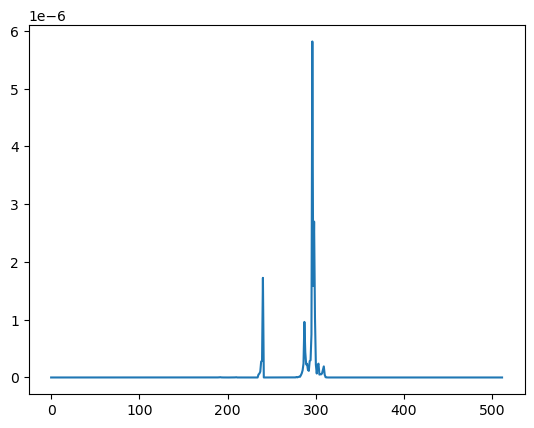

In [33]:
common_images_base = os.path.join("data", "COMMON_images_masks")
files_common_images = os.listdir(common_images_base)
files_common_images = [os.path.join(common_images_base, fil) for fil in files_common_images if ".nii" in fil and "image" in fil]
print(files_common_images[2])

slices = get_slices_from_paths([files_common_images[0]])
images_preprocessed = preprocess_images(slices, shape)
y_pred = model.predict(np.array(images_preprocessed))

import matplotlib.pyplot as plt
plt.plot(range(len(y_pred)), y_pred)
plt.show()

1


In [ ]:



'''
# load group image 
im_base_dir = os.path.join("data", "GROUP_images")
g1_53_image = sitk.ReadImage(os.path.join(im_base_dir, "g1_53_image.nii.gz"), sitk.sitkFloat32, imageIO="NiftiImageIO")
g1_54_image = sitk.ReadImage(os.path.join(im_base_dir, "g1_54_image.nii.gz"), sitk.sitkFloat32, imageIO="NiftiImageIO")
g1_55_image = sitk.ReadImage(os.path.join(im_base_dir, "g1_55_image.nii.gz"), sitk.sitkFloat32, imageIO="NiftiImageIO")

# different size!!!!
print(g1_55_image.GetSize())
print(g1_54_image.GetSize())
print(g1_53_image.GetSize())

g1_53_slices = image_to_slices(g1_53_image)
g1_54_slices = image_to_slices(g1_54_image)
g1_55_slices = image_to_slices(g1_55_image)


#slices = g1_53_slices + g1_54_slices + g1_55_slices

'''